In [1]:
%matplotlib inline
from __future__ import print_function
import numpy
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import pylab

In [2]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[numpy.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

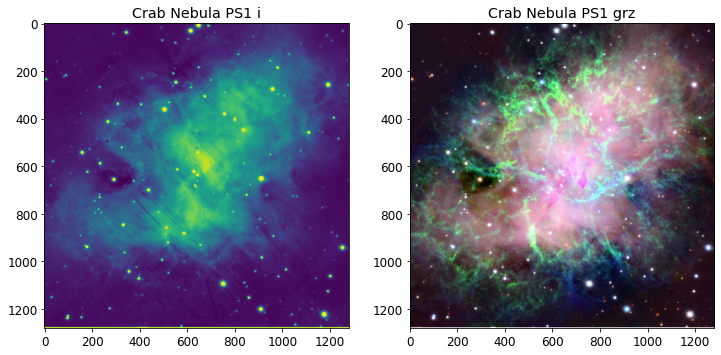

In [3]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i')
pylab.subplot(122)
pylab.title('Crab Nebula PS1 grz')
pylab.imshow(cim,origin="upper")

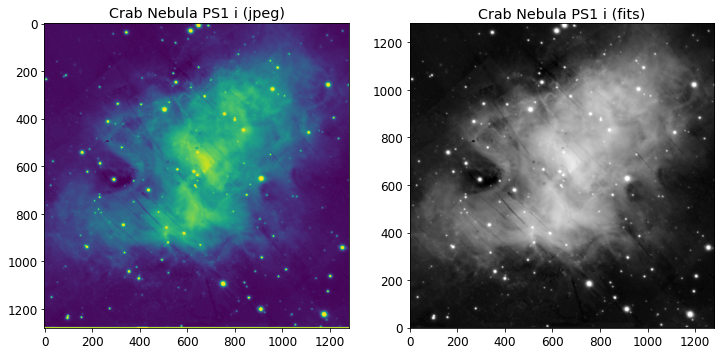

In [4]:
from astropy.io import fits
from astropy.visualization import PercentileInterval, AsinhStretch

fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[numpy.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i (jpeg)')

pylab.subplot(122)
pylab.title('Crab Nebula PS1 i (fits)')
pylab.imshow(bfim,cmap="gray",origin="lower")

In [5]:
#print(fh[0].header)

In [39]:
#from astropy.visualization import PercentileInterval, AsinhStretch
ra = 232.652436800918#83.633210
dec = 42.7171665852056
size = 480
colorim=getcolorim(ra, dec, size=size)

In [45]:
#from astropy.io import fits
#from astropy.visualization import PercentileInterval, AsinhStretch
ra = 232.652436800918#83.633210
dec = 42.7171665852056
size = 480
# pix_size =0.25
#232.652436800918, DEC_PS=42.7171665852056
fitsurl = geturl(ra, dec, size=size, filters="grizy", format="fits")
print(fitsurl[0])
import wget
wget.download(fitsurl[0],'junk.y.fits')
#fh = fits.open(fitsurl[0])
#fh1 = fits.open(fitsurl[1])

#
# MAG=-2.5*log10(∑data-units)+25+2.5*log10(EXPTIME)
#

#print(fh.info())
#fh1 = fits.open(fitsurl[1])

https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=232.652436800918&dec=42.7171665852056&size=480&format=fits&red=/rings.v3.skycell/2201/065/rings.v3.skycell.2201.065.stk.y.unconv.fits


'junk.y (1).fits'

In [32]:
print(list(fh[0].header.keys()))

['SIMPLE', 'BITPIX', 'NAXIS', 'NAXIS1', 'NAXIS2', 'EXTEND', 'COMMENT', 'COMMENT', 'DATE', 'CTYPE1', 'CTYPE2', 'CRVAL1', 'CRVAL2', 'CRPIX1', 'CRPIX2', 'CDELT1', 'CDELT2', 'PC001001', 'PC001002', 'PC002001', 'PC002002', 'HISTORY', 'PSLIB_V', 'HISTORY', 'HISTORY', 'MODULE_V', 'HISTORY', 'HISTORY', 'PHOT_V', 'HISTORY', 'HISTORY', 'STATS_V', 'HISTORY', 'HISTORY', 'STACK_V', 'HISTORY', 'HISTORY', 'NINPUTS', 'STK_TYPE', 'STK_ID', 'SKYCELL', 'TESS_ID', 'AIRM_SLP', 'INP_0000', 'INP_0001', 'INP_0002', 'INP_0003', 'INP_0004', 'INP_0005', 'INP_0006', 'INP_0007', 'INP_0008', 'INP_0009', 'INP_0010', 'INP_0011', 'INP_0012', 'INP_0013', 'INP_0014', 'INP_0015', 'INP_0016', 'INP_0017', 'INP_0018', 'INP_0019', 'INP_0020', 'INP_0021', 'INP_0022', 'INP_0023', 'INP_0024', 'INP_0025', 'INP_0026', 'INP_0027', 'INP_0028', 'INP_0029', 'INP_0030', 'INP_0031', 'SCL_0000', 'SCL_0001', 'SCL_0002', 'SCL_0003', 'SCL_0004', 'SCL_0005', 'SCL_0006', 'SCL_0007', 'SCL_0008', 'SCL_0009', 'SCL_0010', 'SCL_0011', 'SCL_0012',

In [30]:
print(fh[0].header['FPA.ZP'],fh[0].header['ZPT_0001'])
fh1 = fits.open(fitsurl[1])
print(fh1[0].header['FPA.ZP'],fh1[0].header['ZPT_0001'])

25.0 24.62195
25.0 24.70068


In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import os.path
from os import path
from scipy.ndimage import gaussian_filter
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

from astroquery.skyview import SkyView #You might need to install astroquery, other libraries are standard


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


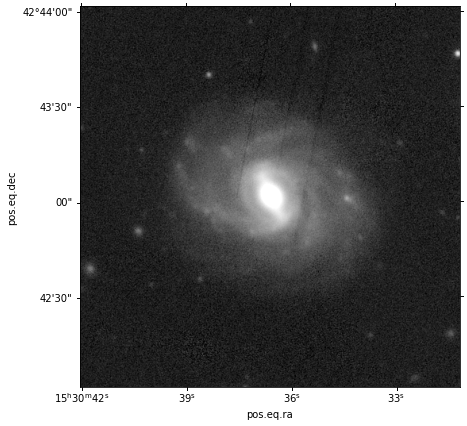

In [24]:
wcs = WCS(fh[0].header)
fig,ax = plt.subplots(figsize=(7,7))
ax=plt.subplot(projection=wcs)
fim = fh[0].data
fim[numpy.isnan(fim)] = 0.0
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)
ax.imshow(bfim,cmap="gray",origin="lower")

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


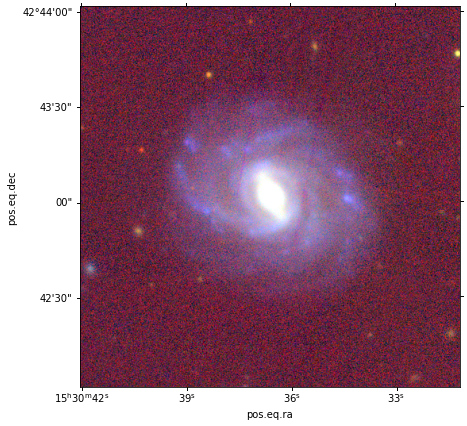

In [42]:
#from astropy.visualization import PercentileInterval, AsinhStretch
ra = 232.652436800918#83.633210
dec = 42.7171665852056
size = 480
colorim=getcolorim(ra, dec, size=size, format='png')

wcs = WCS(fh[0].header)
fig,ax = plt.subplots(figsize=(7,7))
ax=plt.subplot(projection=wcs)
ax.imshow(colorim,origin="lower")

In [44]:
colorim.save("img1.png")